/Users/gianni/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/gianni/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


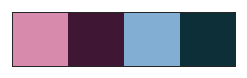

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


from scipy.signal import convolve2d
from statsmodels.formula.api import ols

import lib.reconstruction.errors as errs
import lib.reconstruction.neighbors as nbrs
from lib.utility_functions import *
from lib.exp4 import *

sns.set_style('white')
sns.set_context('paper')

colors = sns.color_palette().as_hex()

pd.set_option('display.max_columns', 40)

% matplotlib inline

# colors = sns.color_palette('Oranges', n_colors=2).as_hex() + sns.color_palette('Blues', n_colors=2).as_hex()
colors = sns.cubehelix_palette(n_colors=2, start=0.5, hue=1, rot=.1, light=.65) 
colors += sns.cubehelix_palette(n_colors=2, start=2.5, hue=1, rot=.1, light=.65)
sns.palplot(colors)

In [7]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)

vals = ['Black Position', 'White Position', 'Is Real']

board_set = tidy.pivot_table(
    index='Position ID', values=vals,
    aggfunc=lambda x: x.unique()[0]
)[vals]
    
adjacencies = board_set.apply(nbrs.get_adjacency, axis=1)
adjacencies_by_location = board_set.apply(nbrs.get_adjacency_per_location, axis=1)

errors_by_location_1 = tidy.apply(
    lambda x: errs.get_errors_per_location(x, errs.error_func_1), 
    axis=1
)
    
tidy['ebl1'] = errors_by_location_1

errors_by_location_2 = tidy.apply(
    lambda x: errs.get_errors_per_location(x, errs.error_func_2), 
    axis=1
)
    
tidy['ebl2'] = errors_by_location_2

errors_by_location_3 = tidy.apply(
    lambda x: errs.get_errors_per_location(x, errs.error_func_3), 
    axis=1
)
    
tidy['ebl3'] = errors_by_location_3

pos_grouped = tidy.groupby('Position ID', )
mean_error_freq_by_loc_1 = pos_grouped.apply(lambda df: np.stack(df['ebl1'], axis=1).mean(axis=1))
mean_error_freq_by_loc_2 = pos_grouped.apply(lambda df: np.stack(df['ebl2'], axis=1).mean(axis=1))
mean_error_freq_by_loc_3 = pos_grouped.apply(lambda df: np.stack(df['ebl3'], axis=1).mean(axis=1))

In [8]:
board_set['ebl1'] = mean_error_freq_by_loc_1
board_set['ebl2'] = mean_error_freq_by_loc_2
board_set['ebl3'] = mean_error_freq_by_loc_3

In [11]:
heatmap_colors = sns.choose_cubehelix_palette()

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

In [22]:
def heat_map(idx, col, ax, board_set_df=board_set):
    mat = board_set_df.loc[idx, col].reshape([4, 9])
    sns.heatmap(
        mat, ax=ax, square=True, cbar=False, cmap=heatmap_colors,
        vmin=0, vmax=1
    )
    
    bp = board_set_df.loc[idx, 'Black Position']
    wp = board_set_df.loc[idx, 'White Position']
    bpf = board_set_df.loc[idx, 'Black Position (final)']
    wpf = board_set_df.loc[idx, 'White Position (final)']
    
    for i in range(36):
        x = i % 9
        y = i // 9
        if bp[i] == '1':
            ax.plot(
                x+.5, y+.5, 
                marker='o', markersize=10, markerfacecolor='black', markeredgecolor='grey'
            )
            
        elif wp[i] == '1':
            ax.plot(
                x+.5, y+.5, 
                marker='o', markersize=10, markerfacecolor='white', markeredgecolor='grey'
            )
            
    return None

KeyError: 'the label [Black Position (final)] is not in the [index]'

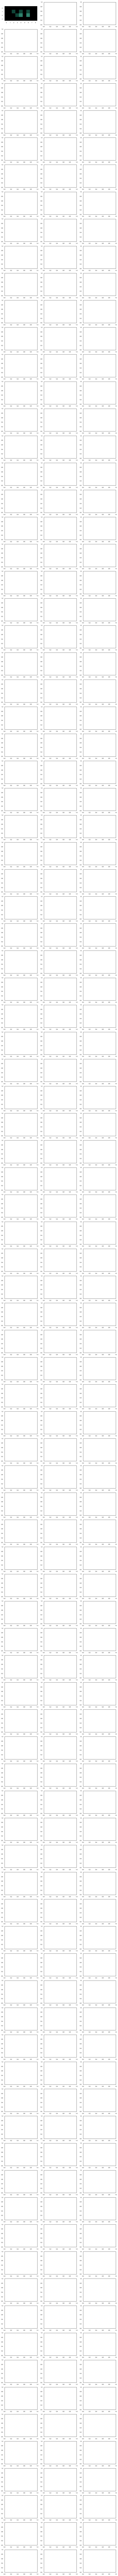

In [23]:
fig, axes = plt.subplots(
    len(board_set.index), 3, 
    figsize=(12, 3 * len(board_set.index)), 
    dpi=60
)

for i, idx in enumerate(board_set.index):
    for j, col in enumerate(['ebl1', 'ebl2', 'ebl3']):
        ax = axes[i, j]
        heat_map(idx, col, ax)
    plt.setp(axes[i, :], xlabel=board_set.loc[idx, 'Is Real'])
    

sns.despine()